# Wine Quality Prediction: Random Forest and Decision Tree Models

---
embed-resources: true
echo: false
---

## Introduction

The purpose of this lab is to build and evaluate predictive models that estimate wine quality using various chemical properties. The goal is to identify which wine characteristics are most predictive of the quality rating and determine how accurately a machine learning model can predict this rating. The dataset contains physicochemical attributes of red and white wines, such as acidity, sugar, alcohol content, and pH, as well as the target variable quality, which is rated on a numerical scale.

We will use a combination of exploratory data analysis and supervised regression models, specifically a Random Forest Regressor and a Decision Tree Regressor, to evaluate prediction accuracy based on Mean Absolute Error (MAE).

## Methods

##### **Data Overview**

The dataset consisted of 1,599 red wine samples, each described by eleven physicochemical properties such as acidity, sugar, sulphates, and alcohol content. The target variable, quality, represented sensory quality ratings assigned by wine tasters on a scale from 0 to 10. Initial exploration confirmed that the ratings were moderately imbalanced, with most wines rated between 5 and 6.

##### **Preprocessing Pipeline and Models**

A preprocessing pipeline was created to ensure consistent data handling and reproducibility across all models.

Numeric Features (fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol):
Missing values were imputed using the median of each feature to maintain data integrity without distorting distributions. Following imputation, features were standardized using StandardScaler to place all predictors on a similar scale, which helps tree-based models maintain stable performance across varying magnitudes.

The dataset was then split into training and testing sets using an 80/20 ratio to evaluate model generalization on unseen data.

##### **Model Development**

Two regression models were implemented for predicting wine quality:

Decision Tree Regressor:
A baseline model was developed using a single Decision Tree. This model is easy to interpret and provides a clear view of feature splits that predict quality ratings. However, it is prone to overfitting, which can reduce its generalization performance.

Random Forest Regressor:
To address overfitting and improve predictive accuracy, an ensemble Random Forest model was trained. Random Forest combines multiple decision trees built on bootstrapped samples of the training data and averages their predictions. This reduces variance and typically results in more robust performance.

##### **Model Evaluation**

Both models were evaluated using Mean Absolute Error (MAE), which measures the average magnitude of prediction errors without considering their direction. Lower MAE values indicate better performance and more accurate predictions of wine quality.

Hyperparameter tuning was performed by adjusting tree depth, number of estimators, and random states to optimize performance and prevent overfitting. Evaluation was conducted using the test set to ensure that model performance reflected real-world generalization.

In [81]:
# imports
# hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

from joblib import dump

#### Variable Descriptions

fixed_acidity

- [float64] concentration of nonvolatile acids in wine (g/dm³)

volatile_acidity

- [float64] concentration of volatile acids that contribute to sourness (g/dm³)

citric_acid

- [float64] concentration of citric acid, which adds freshness and flavor (g/dm³)

residual_sugar

- [float64] amount of sugar left after fermentation (g/dm³)

chlorides

- [float64] salt content of the wine (g/dm³)

free_sulfur_dioxide

- [float64] free form of SO₂, prevents oxidation and microbial growth (mg/dm³)

total_sulfur_dioxide

- [float64] total amount of SO₂ in both bound and free forms (mg/dm³)

density

- [float64] mass per unit volume, related to sugar and alcohol content (g/cm³)

pH

- [float64] measure of acidity or alkalinity

sulphates

- [float64] concentration of potassium sulphate, which affects preservation (g/dm³)

alcohol

- [float64] percentage of ethanol in the wine (%)

quality

- [int64] wine quality rating

### Data

In [82]:
#| echo: true
#| label: data-prep
wine_train = pd.read_parquet(
    "https://lab.cs307.org/wine/data/wine-train.parquet",
)
wine_test = pd.read_parquet(
    "https://lab.cs307.org/wine/data/wine-test.parquet",
)


X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]


wine_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white


In [83]:
# echo: true
# summary statistics
print("--- Feature Summary Statistics (X_train) ---")
print(X_train.describe().transpose())

print("\n--- Target Class Distribution (y_train) ---")
print(y_train.value_counts(normalize=True))


--- Feature Summary Statistics (X_train) ---
                       count        mean        std      min       25%  \
fixed acidity         3987.0    7.220579   1.295282  3.80000   6.40000   
volatile acidity      4157.0    0.342403   0.166465  0.08000   0.23000   
citric acid           3958.0    0.316478   0.145276  0.00000   0.24000   
residual sugar        3917.0    5.430406   4.750618  0.60000   1.80000   
chlorides             4157.0    0.056358   0.035460  0.01200   0.03800   
free sulfur dioxide   4133.0   30.600048  17.906396  1.00000  17.00000   
total sulfur dioxide  4157.0  115.221915  56.581139  6.00000  77.00000   
density               4157.0    0.994710   0.003004  0.98711   0.99238   
pH                    3921.0    3.218454   0.159184  2.74000   3.11000   
sulphates             3934.0    0.531784   0.150914  0.23000   0.43000   
alcohol               3961.0   10.502847   1.189918  8.00000   9.50000   

                           50%        75%        max  
fixed acidi

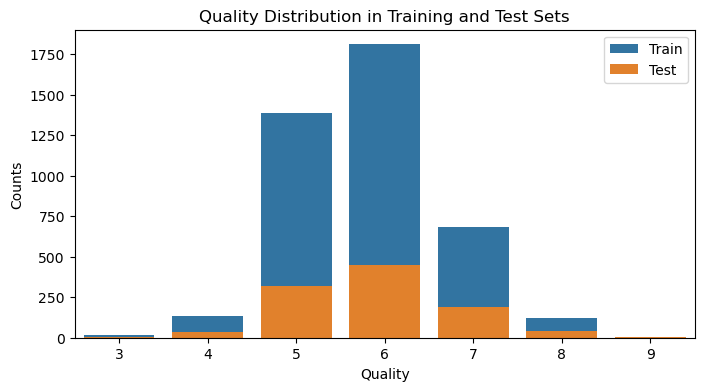

In [84]:
#| echo: true
#| label: fig-quality-distribution
#| fig-cap: "Distribution of wine quality ratings in the training and test datasets"

plt.figure(figsize=(8,4))
sns.countplot(data=wine_train, x="quality", label='Train')
sns.countplot(data=wine_test, x="quality", label='Test')
plt.xlabel("Quality")
plt.ylabel("Counts")
plt.title("Quality Distribution in Training and Test Sets")
plt.legend(['Train','Test'])
plt.show()

This figure shows the distribution of wine quality ratings in both the training and test sets. The data are moderately imbalanced, with most samples clustered around quality scores of 5 and 6.

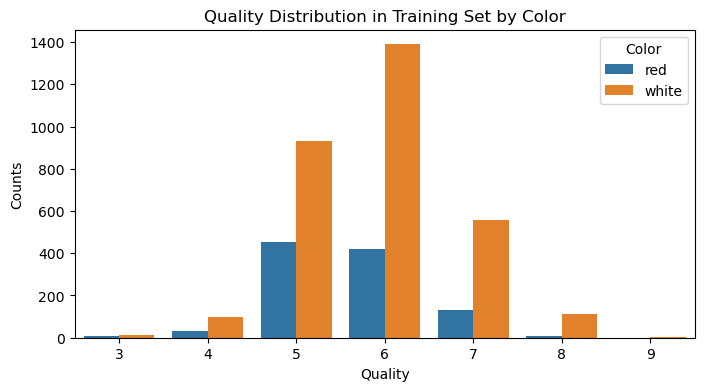

In [85]:
#| echo: true
#| label: fig-quality-by-color
#| fig-cap: "Distribution of wine quality in the training set by color type"

plt.figure(figsize=(8,4))
sns.countplot(data=wine_train, x="quality", hue='color')
plt.xlabel("Quality")
plt.ylabel("Counts")
plt.title("Quality Distribution in Training Set by Color")
plt.legend(title='Color')
plt.show()

This figure displays wine quality counts separated by color. Both red and white wines show similar distributions, though white wines tend to have slightly higher representation in the upper quality categories.

### Models

##### Preprocessing

We used a ColumnTransformer to handle both numeric and categorical features.
Numeric features were imputed using the median and scaled using a StandardScaler.
The categorical feature color was encoded using OneHotEncoder.

In [86]:
# echo: true

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['color']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

column_transformer = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

##### Model 1: Random Forest Regressor

In [87]:
# echo: true
rf_model = Pipeline([
    ('preprocessor', column_transformer),
    ('regressor', RandomForestRegressor(
        n_estimators=400,
        max_depth=16,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
print("Random Forest MAE:", rf_mae)


Random Forest MAE: 0.48284222500567053


##### Model 2: Decision Tree Regressor (with Grid Search)

In [88]:
# echo: true
dt_model = Pipeline([
    ('preprocessor', column_transformer),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

param_grid = {
    'regressor__max_depth': [3, 5, 10, 20, 30, 50, None],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

dt_best = grid_search.best_estimator_
dt_pred = dt_best.predict(X_test)
dt_mae = mean_absolute_error(y_test, dt_pred)
print("Decision Tree MAE:", dt_mae)

Best parameters found: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Decision Tree MAE: 0.5317307692307692


## Results

The Random Forest model achieved a Mean Absolute Error (MAE) of approximately 0.483, while the tuned Decision Tree achieved a MAE of approximately 0.532. Lower MAE indicates higher accuracy, suggesting that the Random Forest model performed better at predicting wine quality

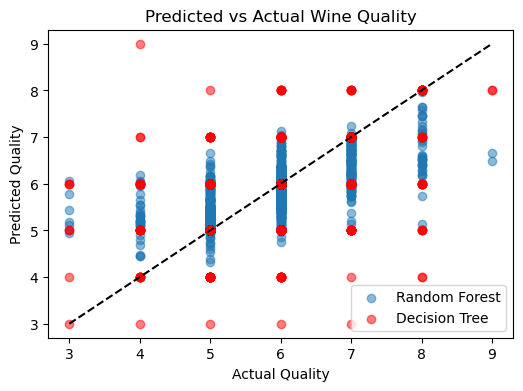

In [89]:
#| echo: true
#| label: fig-predicted-vs-actual
#| fig-cap: "Comparison of predicted versus actual wine quality for Decision Tree and Random Forest models"

plt.figure(figsize=(6,4))
plt.scatter(y_test, rf_pred, alpha=0.5, label='Random Forest')
plt.scatter(y_test, dt_pred, alpha=0.5, label='Decision Tree', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual Wine Quality")
plt.legend()
plt.show()

This figure compares the predicted and actual wine quality ratings for both models. The Random Forest predictions align more closely with the diagonal reference line, indicating higher accuracy and better generalization compared to the Decision Tree.

In [90]:
from joblib import dump
dump(rf_model, 'wine.joblib')


['wine.joblib']

## Discussion

The results show that the Random Forest Regressor was the best model for predicting wine quality. It had a lower Mean Absolute Error (MAE) compared to the Decision Tree Regressor, meaning it made more accurate predictions overall. This model worked better because it uses many smaller trees to make decisions, which helps it balance errors and avoid overfitting to the training data.

The Random Forest model was able to recognize patterns between the different chemical features and the quality ratings. For example, wines with higher alcohol levels and balanced acidity often scored higher in quality. The model could detect these relationships better than the Decision Tree because it looks at many combinations of features at once.

One strength of the Random Forest model is that it gives consistent and reliable predictions. It also performs well even when there is some noise or missing data. However, a major limitation is that it is not very easy to interpret. Unlike the Decision Tree, where you can follow each step of the prediction, the Random Forest works more like a “black box”, meaning it is hard to understand or interpret what is going on on the inside entirely. It also takes longer to train and requires more computer memory.

These results suggest that Random Forest is a strong choice for predicting wine quality and could be useful for winemakers. If used in production, it could help estimate the quality of wine before testing, saving time and improving consistency. To improve the model further, future steps could include testing more advanced methods like gradient boosting, tuning the model’s parameters for even better accuracy, or studying which features influence predictions the most.